# Analysis for once-through scenarios
This notebook provides analysis for all of the once-through fuel cycle scenarios that are included in 
Amanda Bachmann's dissertation. Analysis of each scenario includes the number of reactors deployed, the uranium resources, the SWU capacity, and the amount of waste produced. 

Scenarios are numbers as follows:
* 1: LWRs
* 2: MMR, no growth
* 3: Xe-100, no growth
* 4: Xe-100 and MMR, no growth
* 5: MMR and VOYGR, no growth
* 6: Xe-100 and VOYGR, no growth
* 7: Xe-100, MMR, and VOYGR, no growth
* 8: MMR, 1% growth
* 9: Xe-100, 1% growth
* 10: Xe-100 and MMR, 1% growth
* 11: MMR and VOYGR, 1% growth
* 12: Xe-100 and VOYGR, 1% growth
* 13: Xe-100, MMR, and VOYGR, 1% growth

Analysis of scenario 1 is performed separately, then the no growth scenarios are all analyzed together, followed by the 1% growth scenarios. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import cymetric as cym
sys.path.insert(0,'../../../scripts')
import transition_metrics as tm

In [2]:
# enrichment assays
leu_p = 0.043
mmr_p = 0.13
xe_p = 0.155
voygr_p = 0.0409
x_f = 0.00711
x_t = 0.002

## Scenario 1

In [3]:
s1_outfile = "../outputs/united_states_2020.sqlite"

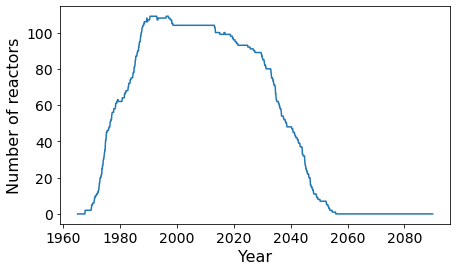

In [4]:
# Reactor Deployment
s1_nonlwr = ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA']
s1_reactors = tm.rx_commission_decommission(s1_outfile, s1_nonlwr)
s1_reactors = tm.add_year(s1_reactors)

plt.figure(figsize=(7,4))
plt.plot(s1_reactors['Year'], s1_reactors['lwr_total'])
plt.xlabel('Year', size=16)
plt.ylabel('Number of reactors', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_reactors.pdf')

In [5]:
s1_metrics = tm.get_metrics(s1_outfile)
s1_agents = s1_metrics.eval("Agents")

In [6]:
print('Total Number of LWRs deployed:', len(s1_agents)-12)
print('Max LWRs deployed:', s1_reactors['lwr_total'].max())
print('LWRS deployed in 2025:', s1_reactors['lwr_total'][721])
print(s1_reactors[['lwr_total','Year']][1087:1095])

Total Number of LWRs deployed: 125
Max LWRs deployed: 109.0
LWRS deployed in 2025: 92.0
Prototype  lwr_total     Year
1087             1.0  2055.58
1088             1.0  2055.67
1089             1.0  2055.75
1090             0.0  2055.83
1091             0.0  2055.92
1092             0.0  2056.00
1093             0.0  2056.08
1094             0.0  2056.17


In [109]:
def get_monthly_electricity(filename):
    evaler = tm.get_metrics(filename)
    electricity = evaler.eval('MonthlyElectricityGeneratedByAgent')
    electricity['Year'] = electricity['Month'] / 12 + 1965
    electricity_output = electricity.groupby(
        ['Month']).Energy.sum().reset_index()
    electricity_output['Energy'] = electricity_output['Energy'] / 1000
    for t in range(0,1499):
        if t not in electricity_output['Month']:
            #print(len(electricity_output)+1)
            electricity_output = electricity_output.append(
                pd.DataFrame(data={'Month':[t], 'Energy': [0.0]}))
    #electricity_output = tm.add_year(electricity_output)
    return electricity_output.sort_values(['Month'])

In [110]:
#energy
s1_energy = get_monthly_electricity(s1_outfile)
s1_energy

,Month,Energy
0,32,0.996
1,33,0.996
2,34,0.996
3,35,0.996
4,36,0.996
...,...,...
0,1494,0.000
0,1495,0.000
0,1496,0.000
0,1497,0.000


Annual electricity for 2025:89.45655 GWe-yr


Monthly electricity for 2025:
* January: 91.448
* February: 91.412
* March: 91.376
* April: 89.396
* May: 88.573
* June: 89.3
* July: 91.130
* August: 84.061
* Spetember: 86.184
* October: 91.514
* November:90.791
* December: 83.104

Text(0, 0.5, 'Energy (GWe-month)')

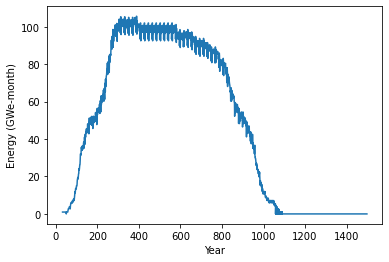

In [112]:
plt.plot(s1_energy['Month'], s1_energy['Energy'])
plt.xlabel('Year')
plt.ylabel('Energy (GWe-month)')

In [7]:
#Uranium resources sent to reactors
s1_transactions = pd.read_csv('current_transactions.csv', 
                                   usecols = ['Time','Commodity', 'Units',
                                             'Quantity','Prototype'])
s1_uox = tm.commodity_mass_traded(s1_transactions, 'fresh_uox')
plt.figure(figsize=(7,4))
plt.plot(s1_uox['Year'], s1_uox['Quantity']/1000)
#plt.legend(loc=2)
plt.ylabel('Mass (t)')
plt.xlabel('Year')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.title('Mass of uranium supplied to all reactors')
plt.savefig('figures/s1_fuelsupply.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'current_transactions.csv'

In [ ]:
print(s1_uox['Quantity'].max())
print(s1_uox['Quantity'].mean())
print(s1_uox['Quantity'][721:1089].mean())

In [ ]:
#Natural uranium needed
s1_tails = tm.calculate_tails(s1_uox['Quantity'], leu_p, x_t, x_f)
s1_feed = tm.calculate_feed(s1_uox['Quantity'], s1_tails)

plt.plot(s1_uox['Year'], s1_feed/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_feed.pdf')

In [ ]:
print(s1_feed.max())
print(s1_feed.mean())
print(s1_feed[721:1089].mean())

In [ ]:
# SWU capacity 
s1_swu = tm.calculate_SWU(s1_uox['Quantity'], leu_p, s1_tails, x_t, s1_feed, x_f)
plt.plot(s1_uox["Year"], s1_swu)
plt.xlabel('Year')
plt.ylabel('SWU (kg-SWU)')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figures/s1_swu.pdf')

In [ ]:
print(s1_swu.max())
print(s1_swu.mean())
print(s1_swu[721:1089].mean())

In [ ]:
# waste discharged
s1_waste = tm.commodity_mass_traded(s1_transactions, 'spent_uox')

plt.plot(s1_waste['Year'], s1_waste['Quantity']/1000)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Mass (t)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('figures/s1_waste.pdf')

In [ ]:
print(s1_waste['Quantity'].max())
print(s1_waste['Quantity'].mean())
print(s1_waste['Quantity'][721:1089].mean())

## No growth scenarios

In [113]:
out_files = {'s2_outfile':"../outputs/mmr_nogrowth.sqlite",
            's3_outfile':"../outputs/xe100_nogrowth.sqlite",
            's4_outfile':"../outputs/xe100_mmr_nogrowth.sqlite",
            's5_outfile':"../outputs/mmr_voygr_nogrowth.sqlite",
            's6_outfile':"../outputs/xe100_voygr_nogrowth.sqlite",
            's7_outfile':"../outputs/xe100_mmr_voygr_nogrowth.sqlite"}

In [4]:
# Reactor Deployment
non_lwr = {'s2': ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR_enter', 'MMR_exit'],
           's3': ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'Xe-100_enter', 'Xe-100_exit'],
           's4': ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'Xe-100', 'MMR'],
           's5': ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'MMR_enter', 'MMR_exit', 'VOYGR_enter', 'VOYGR_exit'],
           's6': ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'Xe-100_enter', 'Xe-100_exit', 'VOYGR_enter', 'VOYGR_exit'],
           's7': ['Sink_HLW', 'Sink_LLW', 'Mine', 'Mill', 'Conversion',
                 'Enrichment', 'FuelFab', 'DryStorage', 'United States',
                 'WetStorage', 'FuelCycle', 'UNITED_STATES_OF_AMERICA',
                 'Xe-100_enter', 'Xe-100_exit', 'MMR', 'VOYGR']
          }
adv_rxs = {'s2':['MMR'], 's3': ['Xe-100'], 's4':['MMR', 'Xe-100'],
           's5':['MMR', 'VOYGR'], 's6':['Xe-100', 'VOYGR'], 
           's7':['Xe-100','MMR', 'VOYGR']}

In [5]:
s2_reactors = tm.reactor_totals(s2_outfile, non_lwr['s2'], adv_rxs['s2'])
s3_reactors = tm.reactor_totals(s3_outfile, non_lwr['s3'], adv_rxs['s3'])
s4_reactors = tm.reactor_totals(s4_outfile, non_lwr['s4'], adv_rxs['s4'])
s5_reactors = tm.reactor_totals(s5_outfile, non_lwr['s5'], adv_rxs['s5'])
s6_reactors = tm.reactor_totals(s6_outfile, non_lwr['s6'], adv_rxs['s6'])
s7_reactors = tm.reactor_totals(s7_outfile, non_lwr['s7'], adv_rxs['s7'])

../../../scripts/transition_metrics.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'][index] = np.round(df['Time'][index] / 12 + 1965, 2)
../../../scripts/transition_metrics.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'][index] = np.round(df['Time'][index] / 12 + 1965, 2)
../../../scripts/transition_metrics.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'][index] = np.round(df['Time'][ind

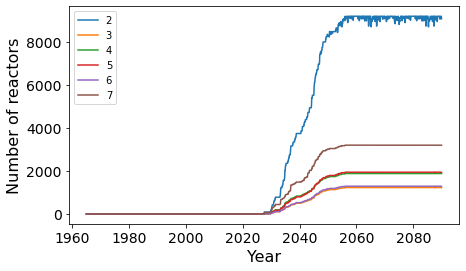

In [6]:
time = np.linspace(1965,2089, 65)
reactors = [s2_reactors, s3_reactors, s4_reactors, s5_reactors, s6_reactors, s7_reactors]
plt.figure(figsize=(7,4))
for reactor_index, reactor in enumerate(reactors):
    plt.plot(reactor['Year'], reactor['advrx_total'], label=reactor_index+2)

plt.xlabel('Year', size=16)
plt.ylabel('Number of reactors', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.yscale('log')
plt.legend()
plt.savefig('figures/nogrowth_reactors.png', bbox_inches='tight')

In [10]:
for reactor_index, reactor in enumerate(reactors):
    rx_key = 's'+ str(reactor_index+2)
    for value in adv_rxs[rx_key]:
        print(f'Max {value} in S{reactor_index+2}:', reactor[value +'_total'].max())
        print(f'Max {value} added in one step in S{reactor_index+2}:', reactor[value +'_enter'].max())
        prototype_sum = reactor[value +'_enter'].cumsum()
        print(f'Total number of {value} deployed in S{reactor_index+2};', prototype_sum.iloc[-1])
    print(f'Max Adv Rx in S{reactor_index+2}:', reactor['advrx_total'].max())
    print(f'Max Adv Rx added in one step in S{reactor_index+2}:', reactor['advrx_enter'].max())
    advrx_sum = reactor['advrx_enter'].cumsum()
    print(f'Total number of reactors deployed in S{reactor_index+2};', advrx_sum.iloc[-1])  

Max MMR in S2: 9182.0
Max MMR added in one step in S2: 378
Total number of MMR deployed in S2; 26681
Max Adv Rx in S2: 9182.0
Max Adv Rx added in one step in S2: 378
Total number of reactors deployed in S2; 26681
Max Xe-100 in S3: 1225.0
Max Xe-100 added in one step in S3: 50
Total number of Xe-100 deployed in S3; 1237
Max Adv Rx in S3: 1225.0
Max Adv Rx added in one step in S3: 50
Total number of reactors deployed in S3; 1237
Max MMR in S4: 752.0
Max MMR added in one step in S4: 31
Total number of MMR deployed in S4; 752
Max Xe-100 in S4: 1124.0
Max Xe-100 added in one step in S4: 50
Total number of Xe-100 deployed in S4; 1124
Max Adv Rx in S4: 1876.0
Max Adv Rx added in one step in S4: 56
Total number of reactors deployed in S4; 1876
Max MMR in S5: 127.0
Max MMR added in one step in S5: 4
Total number of MMR deployed in S5; 366
Max VOYGR in S5: 1811.0
Max VOYGR added in one step in S5: 75
Total number of VOYGR deployed in S5; 1828
Max Adv Rx in S5: 1938.0
Max Adv Rx added in one step

In [115]:
# Energy
energy = {'s2_energy':'', 's3_energy':'', 's4_energy':'',
          's5_energy':'', 's6_energy':'', 's7_energy':''}
for key in energy:
    scenario = key[:2]
    energy[key] = tm.get_monthly_electricity(scenario + '_outfile')

ValueError: The backend database type of 's2_outfile' could not be determined from extension ''.